# Example code for using session.Session

**Note:** This notebook covers several relevant methods of the `Session` and `Stim` objects, detailing some of their arguments, as well. For more details, take a look at the docstring associated with a method of interest.

**Import notes:** 

* Any python packages required by the codebase should be installed and available, if the required conda environment, installed from `osca.yml`, has been activated. 
* `util` is a [Github repo](https://github.com/colleenjg/util/tree/osca_mult) of mine, and the correct branch `osca_mult` is automatically installed from `osca.yml`.  
* **Potential updates:** Errors internal to the codebase involving `util` code and occurring *after* new changes have been pulled from the `OpenScope_CA_Analysis` repo *may* be due to an update of the `osca_mult` branch of `util` that breaks backwards compatibility.  
Though I will try to avoid this, check whether there are updates to the utility, if an error occurs, and consider updating your installation, e.g., by running, from the command line: `pip install -U util-colleenjg`

In [1]:
from pathlib import Path

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

from util import gen_util, logger_util, plot_util
gen_util.extend_sys_path(Path("").resolve(), parents=1)
from analysis import session
from sess_util import sess_gen_util, sess_plot_util

## Plot formatting

If you wish to use the same formatting style as I do:

In [2]:
plot_util.linclab_plt_defaults()

## Set paths to main data directory and the mouse dataframe

### Data directory 

The data directory should contain the session data, either in its **original format** or in **NWB format**.  
* If in NWB format (production data, only), `datadir` should be a directory that contains the data in NWB format, at any depth.  
* If using the data in its original format, `datadir` should specifically be the directory right before the data is split into `prod` (production) and `pilot` (pilot) data.  

### Running on Binder
If the notebook is running on Binder, the dataset is downloaded in NWB format from the [Dandi archive](https://gui.dandiarchive.org/#/dandiset/000037) first, and the data directory is set accordingly.

In [3]:
running_on_binder = False
if "jovyan" in str(Path().resolve()):
    # 'jovyan' is the name of the home directory on Binder
    running_on_binder = True
    print("It appears that this notebook is running on Binder.")

In [4]:
if running_on_binder:
    datadir = Path("..", "data")
    datadir_nwb = datadir
    
    # download data needed for this notebook
    %run ../sess_util/sess_download_util --mouse_ns 1 --output $datadir_nwb --mouse_df ../mouse_df.csv
    %run ../sess_util/sess_download_util --mouse_ns 4 --sess_ns 1 --output $datadir_nwb --mouse_df ../mouse_df.csv
    %run ../sess_util/sess_download_util --mouse_ns 6 --sess_ns 1 --output $datadir_nwb --mouse_df ../mouse_df.csv

else:
    datadir = Path("..", "..", "data", "OSCA") # can be identical to datadir_nwb
    datadir_nwb = Path("..", "..", "data", "OSCA_NWB")
    print(
        "Be sure to download the dataset, and update `datadir` and `datadir_nwb` to point "
        f"to its location.\nCurrently they point to {datadir} and {datadir_nwb}, respectively."
    )

Be sure to download the dataset, and update `datadir` and `datadir_nwb` to point to its location.
Currently they point to ../../data/OSCA and ../../data/OSCA_NWB, respectively.


### Mouse dataframe

The mouse dataframe, contains the metadata for each session, including its 9-digit `sessid`, the `mouse_n`, `sess_n`, etc.

In [5]:
mouse_df = pd.read_csv(Path("..", "mouse_df.csv"))

**Mouse dataframe columns:**  
* **`sessid`**: Unique session ID (9-digit)  
* **`dandi_session_id`**: Dandiset session ID for data in NWB format.  
* **`mouse_n`**: Mouse number  
* **`mouseid`**: Unique mouse ID (6-digit)  
* **`date`**: Recording date  
* **`depth`**: Recording depth (um)  
* **`plane`**: Recording plane ("dend" or "soma")  
* **`line`**: Cell line ("L2/3-Cux2" or "L5-Rbp4")  
* **`runtype`**: Type of session ("pilot" or "prod"). Only production data is available in NWB dataset.   
* **`sess_n`**: Session number  
* **`nrois`**: Number of valid ROIs (see _**Note**_)  
* **`nrois_tracked`**: Number of ROIs tracked across sessions (-1 for sessions with no tracking).    
* **`nrois_all`**: Same as **`nrois`**, but including bad (non valid) ROIs.  
* **`nrois_allen`**: Number of valid ROIs when using the `allen` segmentation for dendritic ROIs, instead of the `extr` segmentation (see _**Note**_).  
* **`nrois_allen_all`**: Same as **`nrois_allen`**, but including bad (non valid) ROIs.  
* **`pass_fail`**: Whether the session passed (`P`) or failed (`F`) quality control.  
* **`all_files`**: Whether all files are available for the session (original data format).  
* **`any_files`**: Whether any files are available for the session (original data format).  
* **`incl`**: Whether the session can be included in analyses (looser criterion than **`pass_fail`**).  
* **`stim_seed`**: Seed used to initialize stimuli for the session, during recording.  
* **`notes`**: Any notes on the session.  

**_Note:_** The `allen` segmentations are used for all **somatic** data. The `extr` segmentations are preferred for all **dendritic** data. For this reason, the `allen` segmentation for **dendritic** data is _**not included**_ in the NWB dataset. See **section 6** for details on `allen` and `extr` ROI mask types.


In [6]:
mouse_df

,sessid,dandi_session_id,mouse_n,mouseid,date,depth,plane,line,runtype,sess_n,...,nrois_tracked,nrois_all,nrois_allen,nrois_allen_all,pass_fail,all_files,any_files,incl,stim_seed,notes
0,712483302,NaN,1,389778,20180621,20,dend,L5-Rbp4,pilot,1,...,-1,1468,232,259,F,1,1,yes,103,"dropped beh and eye tracking frames (7), stim ..."
1,712942208,NaN,1,389778,20180622,375,soma,L5-Rbp4,pilot,2,...,-1,78,62,78,F,1,1,yes,103,"dropped beh and eye tracking frames (6), stim ..."
2,714893802,NaN,1,389778,20180627,20,dend,L5-Rbp4,pilot,3,...,-1,-1,-1,-1,F,0,1,no,103,missing 2P recordings and ROI traces
3,715244457,NaN,1,389778,20180628,20,dend,L5-Rbp4,pilot,4,...,-1,949,458,504,P,1,1,yes,103,NaN
4,716425232,NaN,1,389778,20180702,375,soma,L5-Rbp4,pilot,5,...,-1,79,56,79,P,1,1,yes,103,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78,833704570,20190307T163524,13,440889,20190307,175,soma,L23-Cux2,prod,2,...,147,251,224,251,P,1,1,yes,16745,stim2twop alignment shifted corrected with 2nd...
79,834403597,20190308T164555,13,440889,20190308,175,soma,L23-Cux2,prod,3,...,147,228,210,228,P,1,1,yes,10210,"dropped beh and eye tracking frames (6), stim ..."
80,836968429,20190314T152429,13,440889,20190314,175,soma,L23-Cux2,prod,4,...,-1,217,205,217,P,1,1,yes,24253,FOV shifted (poor alignment with previous sess...
81,837360280,20190315T152224,13,440889,20190315,175,soma,L23-Cux2,prod,5,...,-1,244,217,244,F,1,1,yes,19576,z-drift (14 um)


## 1. Basics of initializing a Session object

Sessions can be intialized with their 9-digit `sessid`:

In [7]:
sess = session.Session(760260459, datadir=datadir, mouse_df=mouse_df)

or with their `mouse_n`, `sess_n` and `runtype`:

In [8]:
sess = session.Session(mouse_n=4, sess_n=1, runtype="prod", datadir=datadir, mouse_df=mouse_df)

### Data format is identified automatically 

During initialization, the code looks first for the session data in NWB format, under its `dandi_session_id`. If it doesn't find it, it looks for the data in its original format. If neither are found, an error is thrown.

### Loading the data after initialization.

After creating the session, you must run `self.extract_info()`. 
This wasn't amalgamated into the `__init__` to reduce the amount of information needed to just create a session object.

### Loading ROI/running/pupil info

You can load this information when you call `self.extract_info()` or manually later by calling `self.load_roi_info()`, `self.load_run_data()` and `self.load_pup_data()`. 

In [9]:
sess.extract_info(full_table=False, roi=True, run=True, pupil=True) 

Loading stimulus and alignment info...
Loading ROI trace info...
Loading running info...
Loading pupil info...


### Stimulus dataframe

The stimulus dataframe, stored under `sess.stim_df`, details the stimulus feature for each segment of the presentation.  
A **segment** is the minimal subdivision of the stimulus presentation: **0.3 sec** for the Gabor stimulus, and **1s** for the visual flow, and grayscreen stimuli.  
  
If a feature **does not apply** to certain segments (e.g., `gabor_number` for visual flow stimulus segments), the values for those segments will be `None`, `NaN` or `[]`, depending on the column's datatype.

**Missing columns**: Note that a few columns are missing, since the session was loaded with `full_table=False`. 
* `"gabor_orientations"`: Specific orientation of each Gabor patch, for each segment.
* `"square_locations_x"`: Specific x location of each visual flow square, at **each frame** of each segment.
* `"square_locations_y"`: Specific y location of each visual flow square, at **each frame** of each segment.

This is primarily to save memory, when loading a session, as this information is not typically needed.  
To load all columns, re-run `sess.extract_info()` with `full_table=True`. Data that is already loaded will not be re-loaded. 

In [10]:
sess.stim_df

,stimulus_type,stimulus_template_name,unexpected,gabor_frame,gabor_kappa,gabor_mean_orientation,gabor_number,gabor_locations_x,gabor_locations_y,gabor_sizes,...,square_proportion_flipped,start_frame_stim,stop_frame_stim,num_frames_stim,start_frame_twop,stop_frame_twop,num_frames_twop,start_time_sec,stop_time_sec,duration_sec
0,grayscreen,grayscreen,NaN,,NaN,NaN,NaN,[],[],[],...,NaN,0,1800,1800,143,1046,903,14.30646,44.332150,30.025690
1,gabors,gabors,0.0,A,16.0,0.0,30.0,"[-314.2481536790383, 726.6351926350328, -609.4...","[519.3985635606798, 429.54112277826425, 482.75...","[237, 382, 341, 269, 332, 300, 256, 322, 252, ...",...,NaN,1800,1818,18,1046,1055,9,44.33215,44.639380,0.307230
2,gabors,gabors,0.0,B,16.0,0.0,30.0,"[278.93714376420894, -895.0169462360316, 830.4...","[-62.92603512701612, -329.96944361291634, -332...","[355, 245, 207, 246, 209, 371, 209, 400, 214, ...",...,NaN,1818,1836,18,1055,1064,9,44.63938,44.939040,0.299660
3,gabors,gabors,0.0,C,16.0,0.0,30.0,"[-694.2565883378384, 458.8415680953749, -472.6...","[162.5089263895926, 433.50619201931613, 567.71...","[270, 274, 369, 230, 364, 205, 360, 315, 396, ...",...,NaN,1836,1854,18,1064,1073,9,44.93904,45.232430,0.293390
4,gabors,gabors,0.0,D,16.0,0.0,30.0,"[-631.2261180219028, -600.2310528361336, -887....","[-21.003509639097615, -271.4924294875755, 555....","[228, 332, 237, 248, 346, 308, 333, 277, 232, ...",...,NaN,1854,1872,18,1073,1082,9,45.23243,45.526750,0.294320
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8839,visflow,visflow_right,0.0,,NaN,NaN,NaN,[],[],[],...,0.00,249960,250020,60,125551,125581,30,4183.68954,4184.690500,1.000960
8840,visflow,visflow_right,0.0,,NaN,NaN,NaN,[],[],[],...,0.00,250020,250080,60,125581,125611,30,4184.69050,4185.691070,1.000570
8841,visflow,visflow_right,1.0,,NaN,NaN,NaN,[],[],[],...,0.25,250080,250140,60,125611,125641,30,4185.69107,4186.692190,1.001120
8842,visflow,visflow_right,1.0,,NaN,NaN,NaN,[],[],[],...,0.25,250140,250200,60,125641,125672,31,4186.69219,4187.690570,0.998380


### Stimulus objects

Once `sess.extract_info()`, each Session object now contains `Stim` objects. 

These come in one of three subclasses: `Gabors`, `Visflow`, `Grayscr`, and can be accessed with:
`sess.stims`, `sess.gabors`, `sess.visflow`, `sess.grayscr`.

The the `Stim` object `stim`, the Session object can be accessed with `stim.sess`.

In [11]:
print(f"number of rois         : {sess.get_nrois()}")
print(f"mouse number           : {sess.mouse_n}")
print(f"mouse ID               : {sess.mouseid}")
print(f"gabor object           : {sess.gabors}")
print(f"2p frames per sec      : {sess.twop_fps:.2f}")
print(f"stimulus frames per sec: {sess.stim_fps:.2f}")

number of rois         : 90
mouse number           : 4
mouse ID               : 411771
gabor object           : Gabors (stimulus from session 760260459)
2p frames per sec      : 30.08
stimulus frames per sec: 59.95


## 2. Retrieving data of interest

### Identifying stimulus segments of interest

From a `Session`'s `Stim`, you can get a list of segments that fit a specific criterion, e.g. **U segments** (unexpected, 3rd Gabor frame).

In [12]:
gab_seg_ns = sess.gabors.get_segs_by_criteria(gabk=16, gabfr=3, unexp=1, by="seg")

### Identifying frame numbers of interest, to index the data

Then, you can retrieve the exact frame numbers that match these segments.

Specifically, you can access:
* `twop` frame numbers, which index the two-photon data and pupil data, and 
* `stim` frame numbers, which index the running data.

**Note:** When retrieving the frame numbers, specifying `ch_fl` (check flanks) ensures that only frame numbers whose flanks are within the recording are returned. In other words, any frame number too close to the start or end of the recording (based on `pre`/`post` values), will be dropped.

In [13]:
pre = 1.0
post = 1.0
twop_fr_ns = sess.gabors.get_fr_by_seg(
    gab_seg_ns, start=True, ch_fl=[pre, post], fr_type="twop"
    )["start_frame_twop"]
stim_fr_ns = sess.gabors.get_fr_by_seg(
    gab_seg_ns, start=True, ch_fl=[pre, post], fr_type="stim"
    )["start_frame_stim"]

### Retrieving the data of interest

You can now get the **ROI / running / pupil data** corresponding to these reference frames and the specified `pre` / `post` periods (in sec).  

In [14]:
roi_data_df = sess.gabors.get_roi_data(twop_fr_ns, pre, post, scale=True)
run_data_df = sess.gabors.get_run_data(stim_fr_ns, pre, post, scale=True)
pup_data_df = sess.gabors.get_pup_diam_data(twop_fr_ns, pre, post, scale=True)

### Retrieving data statistics of interest

You can also directly obtain statistics on the data of interest.

In [15]:
roi_stats_df = sess.gabors.get_roi_stats_df(
    twop_fr_ns, pre, post, integ=True, stats="mean", error="sem", byroi=False
)
roi_stats_df

datatype               roi_traces
bad_rois_removed              yes
scaled                         no
baseline                       no
integrated                    yes
smoothing                      no
fluorescence                  dff
general ROIs sequences           
stats   None stat_mean   0.062516
             error_SEM   0.017370

### Using hierarchical dataframes

Data and statistics are returned in a hierarchical dataframe with **columns** and **indices**.

This has the advantage of allowing metadata to be stored in dummy columns, however extracting data from these dataframes can be tricky, syntactically.

In [16]:
roi_data_df

datatype                   roi_traces
bad_rois_removed                  yes
scaled                            yes
baseline                           no
integrated                         no
smoothing                          no
fluorescence                      dff
ROIs sequences time_values           
0    0         -1.000000    -0.338172
               -0.966102     0.155122
               -0.932203     0.150821
               -0.898305     0.053135
               -0.864407    -0.100729
...                               ...
102  81         0.864407     0.297796
                0.898305    -0.031714
                0.932203     0.339743
                0.966102     0.524661
                1.000000    -0.289968

[442800 rows x 1 columns]

To **extract a numpy array** with the correct dimensions from a hierarchical dataframe, you can use the following utility function: `gen_util.reshape_df_data()`.

Here, each index level, then column level is turned into a new axis, **i.e. ROIs x sequences x time_values** (In this case, `squeeze_cols` is set to True to prevent each dummy column from becoming its own axis.)

In [17]:
roi_data = gen_util.reshape_df_data(roi_data_df, squeeze_cols=True)
print("ROI data shape: {} ROIs x {} sequences x {} time values".format(*roi_data.shape))

ROI data shape: 90 ROIs x 82 sequences x 60 time values


You can also retrieve the time stamps for each frame.

In [18]:
xran = roi_data_df.index.unique("time_values")

### Visualizing the data

Finally, we can plot each ROIs mean activity across sequences, as well as a mean across ROIs.

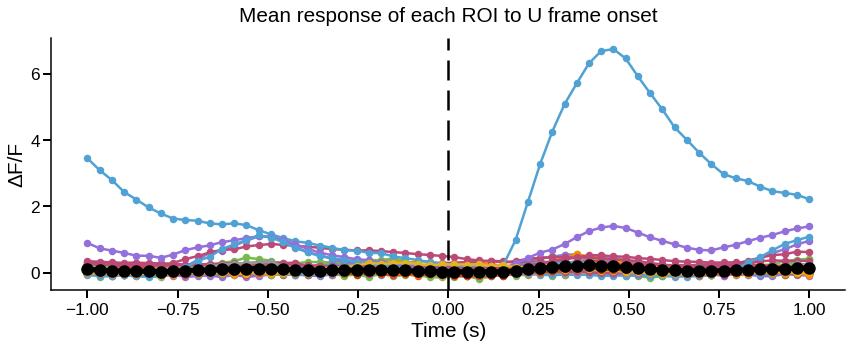

In [19]:
fig, ax = plt.subplots(1, figsize=(12, 5))
_ = ax.plot(xran, np.mean(roi_data, axis=1).T, marker=".") # mean per ROI
_ = ax.plot(xran, np.mean(np.mean(roi_data, axis=1).T, axis=1), 
            lw=5, c="k", marker="o") # mean across ROIs
_ = ax.axvline(0, c="k", ls="dashed")
_ = ax.set_title("Mean response of each ROI to U frame onset", y=1.04)
_ = ax.set_xlabel("Time (s)")
delta = u"\u0394"
_ = ax.set_ylabel(u"{}F/F".format(delta))

### The same steps apply for Visflow

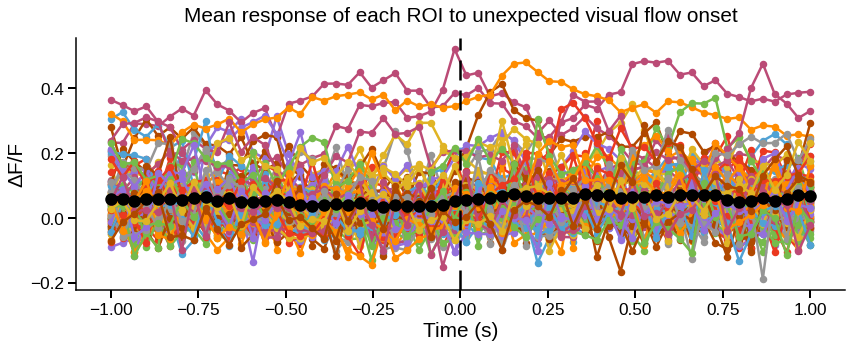

In [20]:
visflow_seg_ns = sess.visflow.get_segs_by_criteria(visflow_size=128, unexp=1, remconsec=True, by="seg")

pre = 1.0
post = 1.0
twop_fr_ns = sess.visflow.get_fr_by_seg(
    visflow_seg_ns, start=True, ch_fl=[pre, post], fr_type="twop")["start_frame_twop"]

roi_data_df = sess.visflow.get_roi_data(twop_fr_ns, pre, post, scale=True)
roi_data = gen_util.reshape_df_data(roi_data_df, squeeze_cols=True)
xran = roi_data_df.index.unique("time_values")

fig, ax = plt.subplots(1, figsize=(12, 5))
_ = ax.plot(xran, np.mean(roi_data, axis=1).T, marker=".") # mean per ROI
_ = ax.plot(xran, np.mean(np.mean(roi_data, axis=1).T, axis=1), 
            lw=5, c="k", marker="o") # mean across ROIs
_ = ax.axvline(0, c="k", ls="dashed")
_ = ax.set_title("Mean response of each ROI to unexpected visual flow onset", y=1.04)
_ = ax.set_xlabel("Time (s)")
delta = u"\u0394"
_ = ax.set_ylabel(u"{}F/F".format(delta))

## 3. Tracked ROIs

ROI tracking was performed on the `production` data.  
At any point, it is possible to **restrict the data returned** to only the tracked ROIs, called `sess.set_only_tracked_rois(True)`.

In [21]:
sess.set_only_tracked_rois(True)

Here, we retrieve the data, **integrated over each sequence**.

In [22]:
tracked_roi_data_df = sess.visflow.get_roi_data(twop_fr_ns, pre, post, scale=True, integ=True)

The dataframe returned contains data only for tracked ROIs.

In [23]:
tracked_roi_data_df

datatype         roi_traces
bad_rois_removed        yes
scaled                  yes
baseline                 no
integrated              yes
smoothing                no
fluorescence            dff
ROIs sequences             
28   0             0.101591
     1             0.188843
     2            -0.072082
     3             0.685275
     4             0.033439
...                     ...
22   27            0.026887
     28            0.523182
     29           -0.039192
     30           -0.059955
     31            0.080472

[1504 rows x 1 columns]

### Extracting tracked ROI data correctly (!)

**Importantly**, the ROIs are now sorted in their tracking order, which ensures that they are correctly aligned across sessions.  
As a result, the **"ROIs" index** may no longer be in increasing order, like in this example.

In [24]:
roi_ns_ordered = tracked_roi_data_df.index.unique("ROIs").to_numpy()
print(f"ROI numbers, ordered for tracking:\n{', '.join([str(roi_n) for roi_n in roi_ns_ordered])}")

ROI numbers, ordered for tracking:
28, 69, 90, 2, 55, 7, 5, 73, 101, 16, 93, 85, 84, 17, 15, 18, 29, 26, 13, 48, 1, 74, 25, 87, 72, 88, 89, 76, 0, 78, 67, 57, 62, 50, 42, 41, 43, 14, 32, 6, 45, 46, 98, 44, 27, 34, 22


To **ensure that the tracked ROI order is preserved** when extracting the data, the safest option is to use the utility function introduced above, i.e. `gen_util.reshape_data_df()`. It will ensure that the order is preserved.

In [25]:
tracked_roi_data = gen_util.reshape_df_data(tracked_roi_data_df, squeeze_cols=True)
print("Tracked ROI data shape using the correct method, i.e., gen_util.reshape_df_data()"
      "\n{} ROIs x {} sequences".format(*tracked_roi_data.shape))

Tracked ROI data shape using the correct method, i.e., gen_util.reshape_df_data()
47 ROIs x 32 sequences


**Do not use the `.unstack()` method for hierarchical dataframes!**

Even though the `.unstack()` method is typically a convenient way to extract a 2D array from a hierarchical dataframe, it will cause major problems here. Specifically, `.unstack()` internally triggers a resorting of the hierarchical indices. Thus, using it will completely mess up the tracked ROI order.

In [26]:
tracked_roi_data_wrong = tracked_roi_data_df.unstack().to_numpy()
print("Tracked ROI data shape using the wrong method, i.e., .unstack()"
      "\n{} ROIs x {} sequences".format(*tracked_roi_data_wrong.shape))

Tracked ROI data shape using the wrong method, i.e., .unstack()
47 ROIs x 32 sequences


As you can see, the dimensions are still correct. However, the **ROI sorting is actually lost!**  

For example, **ROI #5**, which should appear at index 6 in the array, is now at index 3.

In [27]:
roi_idx_6_data = tracked_roi_data[6, :10]
print(f"Data for the tracked ROI at index 6, when using the correct method: i.e., gen_util.reshape_df_data()"
      f"\n{', '.join([f'{val:.3f}' for val in roi_idx_6_data])} ...")

Data for the tracked ROI at index 6, when using the correct method: i.e., gen_util.reshape_df_data()
0.005, 0.024, -0.050, -0.553, 0.629, -0.051, -0.057, 0.071, -0.003, -0.067 ...


In [28]:
roi_idx_6_data_wrong = tracked_roi_data_wrong[6, :10]
print(f"Data for the tracked ROI at index 6, when using the wrong method: i.e., .unstack()"
      f"\n{', '.join([f'{val:.3f}' for val in roi_idx_6_data_wrong])} ...")

Data for the tracked ROI at index 6, when using the wrong method: i.e., .unstack()
0.053, 0.191, 0.232, -0.004, -0.008, 0.060, 0.083, -0.031, 0.015, 0.024 ...


In [29]:
roi_idx_3_data_wrong = tracked_roi_data_wrong[3, :10]
print(f"Data for the tracked ROI that should be at index 6 is instead at index 3,\n"
      "when using the wrong method: i.e., .unstack()"
      f"\n{', '.join([f'{val:.3f}' for val in roi_idx_3_data_wrong])} ...")

Data for the tracked ROI that should be at index 6 is instead at index 3,
when using the wrong method: i.e., .unstack()
0.005, 0.024, -0.050, -0.553, 0.629, -0.051, -0.057, 0.071, -0.003, -0.067 ...


### Reset the session to start using all ROIs, again

In [30]:
sess.set_only_tracked_rois(False)

## 4. Additional tips on indexing a hierarchical dataframe

In [31]:
# getting columns
roi_data_series = roi_data_df["roi_traces"]

# getting specific ROIs, from their IDs, e.g. (0, 3, 5)
roi_data_specific_rois = roi_data_df.loc[([0, 3, 5])]

# getting specific sequences (0, 3, 5) for all ROIs <- second order index, so requires a pandas slice
roi_data_specific_seqs = roi_data_df.loc[(pd.IndexSlice[:, [1, 20, 21]]), ]

# using both index and columns
roi_data_specific = roi_data_df.loc[(pd.IndexSlice[[0, 3, 5], [1, 20, 21], -1]), ("roi_traces", "yes")]
roi_data_specific

scaled                           yes
baseline                          no
integrated                        no
smoothing                         no
fluorescence                     dff
ROIs sequences time_values          
0    1         -1.0        -0.183646
     20        -1.0         0.013693
     21        -1.0        -0.091127
3    1         -1.0         0.221201
     20        -1.0         0.347209
     21        -1.0        -0.163844
5    1         -1.0        -0.243460
     20        -1.0        -0.422120
     21        -1.0         0.203985

## 5. Retrieving several Session objects, based on criteria

### Identifying mice or session IDs to omit (pilot data only)

`sess_gen_util.all_omit()` allows keeping track of **which session IDs or mice must be left out**.  

This actually **only applies to `pilot` data**, where some mice did not see all the stimuli of interst, and one session has incomplete data.  
For the `prod` data, the lists are empy.

In [32]:
omit_sess, omit_mice = sess_gen_util.all_omit(runtype="prod")

### Retrieving mouse / session numbers and IDs that fit specific criteria

`sess_gen_util.get_sess_vals()` can be used to retrieve information for sessions that meet certain criteria.  
e.g., **session number 1, 2 or 3**, **production**, **dendritic plane**

In [33]:
mouse_ns, sess_ns, sessids = sess_gen_util.get_sess_vals(
    mouse_df, ["mouse_n", "sess_n", "sessid"], sess_n=[1, 2, 3], runtype="prod", plane="soma", omit_sess=omit_sess, 
    omit_mice=omit_mice, unique=False)

In [34]:
print("\n".join([f"mouse {m:2}: {sid} (session {n})" for m, sid, n in zip(mouse_ns, sessids, sess_ns)]))

mouse  1: 758519303 (session 1)
mouse  1: 759189643 (session 2)
mouse  1: 759660390 (session 3)
mouse  3: 761624763 (session 1)
mouse  3: 761944562 (session 2)
mouse  3: 762250376 (session 3)
mouse  4: 760260459 (session 1)
mouse  4: 760659782 (session 2)
mouse  4: 761269197 (session 3)
mouse  7: 777496949 (session 1)
mouse  7: 778374308 (session 2)
mouse  7: 779152062 (session 3)
mouse 12: 826659257 (session 1)
mouse 12: 827300090 (session 2)
mouse 12: 828475005 (session 3)
mouse 13: 832883243 (session 1)
mouse 13: 833704570 (session 2)
mouse 13: 834403597 (session 3)


### Loading the sessions

`sess_gen_util.init_sessions()` can be used to **initialize the sessions** and **extract the requested data**.

In [35]:
soma_sessions = sess_gen_util.init_sessions(
    sessids[:3], datadir, mouse_df, full_table=False, omit=True, runtype="prod", 
    roi=True, run=True
)

dend_sessions = sess_gen_util.init_sessions(
    [764704289], datadir, mouse_df, full_table=False, omit=True, runtype="prod", 
    roi=True, run=True
)


Creating session 758519303...
Loading stimulus and alignment info...
Loading ROI trace info...
Loading running info...
Finished creating session 758519303.

Creating session 759189643...
Loading stimulus and alignment info...
Loading ROI trace info...
Loading running info...
Finished creating session 759189643.

Creating session 759660390...
Loading stimulus and alignment info...
Loading ROI trace info...
Loading running info...
Finished creating session 759660390.

Creating session 764704289...
Loading stimulus and alignment info...
Loading ROI trace info...
Loading running info...
Finished creating session 764704289.


### Using the loaded sessions

Now, one can run through the sessions, and run whatever analysis is needed.

Note here that, when calling `stim.get_segs_by_criteria()`, **features that do not apply to the stimulus** (e.g., `gabfr` for the `visflow` stimulus) **are simply ignored**. 

In [36]:
for sess in soma_sessions + dend_sessions:
    print(f"Session ID: {sess.sessid} (mouse {sess.mouse_n}, session {sess.sess_n})")
    for stimtype in ["visflow", "gabors"]:
        stim = sess.get_stim(stimtype)
        segs = stim.get_segs_by_criteria(
            visflow_size=128, unexp=1, gabk=16, gabfr=3, by="seg", 
            remconsec=(stimtype == "visflow")
            )
        print(f"    {stimtype}: {len(segs)} sequences")

Session ID: 758519303 (mouse 1, session 1)
    visflow: 31 sequences
    gabors: 94 sequences
Session ID: 759189643 (mouse 1, session 2)
    visflow: 34 sequences
    gabors: 90 sequences
Session ID: 759660390 (mouse 1, session 3)
    visflow: 33 sequences
    gabors: 105 sequences
Session ID: 764704289 (mouse 6, session 1)
    visflow: 33 sequences
    gabors: 96 sequences


## 6. Retrieving ROI masks from a session

Boolean ROI masks can be obtained for each Session.

### Dendritic mask types

For **dendritic sessions**, the Session is built to assume that `extr` (not `allen`) ROI data is to be used. This can be checked by checking `self.dend`. As long as `self.dend` is properly set, the correct ROI data and masks will be loaded.  

The `allen` masks were extracted with a pipeline tailored to somatic ROIs, and are therefore not preferred for dendritic data.  
In contrast, the `extr` masks were extracted with the EXTRACT pipeline, which specifically enables dendrite-shaped ROIs to be identified.  

Note that, for this reason, _**only the `extr` dendritic ROIs and masks**_ are included in the data in NWB formatted data.

In [37]:
dend_sess = dend_sessions[0]
print(f"Dendritic session, ROI type: {dend_sess.dend}")

soma_sess = soma_sessions[0]
print(f"Somatic session, ROI type: {soma_sess.dend}")

Dendritic session, ROI type: extr
Somatic session, ROI type: allen


### Loading masks

Masks can be loaded as follows, with dimensions: **ROI x height x width**, retrieving only masks for ROIs that are valid (when evaluated by their dF/F traces).  

Notes: 
- **If sessions are set to use only tracked ROIs**, as described above, only masks for the tracked ROIs (sorted in the tracking order) will be returned.
- If running this notebook on **Binder**, the dendritic masks are not loaded, as the memory requirements are too high (~2-3GB).

In [38]:
soma_mask = soma_sess.get_roi_masks()
if not running_on_binder:
    dend_mask = dend_sess.get_roi_masks()

In most functions, by default, ROIs that are considered **bad (non valid)** are automatically removed (`rem_bad=True`).  
Note that, **for the NWB data**, the _**bad ROIs were removed altogether**_.  

These ROIs either:  
**(1) contain NaN/Infs values** or  
**(2) have been deemed too noisy**.

If, for whatever reason, **all masks are needed**, including those for the bad ROIs,  
**(1)** ensure that the session is currently set to return all ROI data, with `sess.only_tracked_rois(False)`, then  
**(2)** call `self.get_roi_masks(rem_bad=False)`.

Of course, as explained above, if using the NWB data, there are no bad ROIs. 

In [39]:
soma_sess.set_only_tracked_rois(False)
soma_mask_all = soma_sess.get_roi_masks(rem_bad=False)

if not running_on_binder:
    dend_sess.set_only_tracked_rois(False)
    dend_mask_all = dend_sess.get_roi_masks(rem_bad=False)

### Bad ROIs 

When using the data in its **original format**, one can get a list of bad ROIs, by using `self.get_bad_rois()`. 

If the data is in **NWB format**, there should be **no bad ROIs**, as they have already been removed.

In [40]:
soma_nan_masks = np.asarray(soma_sess.get_bad_rois(fluor="dff"))
soma_valid = np.ones(len(soma_mask_all))
if len(soma_nan_masks):
    soma_valid[soma_nan_masks] = 0

if not running_on_binder:
    dend_nan_masks = np.asarray(dend_sess.get_bad_rois(fluor="dff"))
    dend_valid = np.ones(len(dend_mask_all))
    if len(dend_nan_masks):
        dend_valid[dend_nan_masks] = 0

### Visualizing ROI masks

`sess_plot_util.plot_ROIs()` can be used to visualize ROIs, where specific ROIs can be set to red using a `valid_mask`.

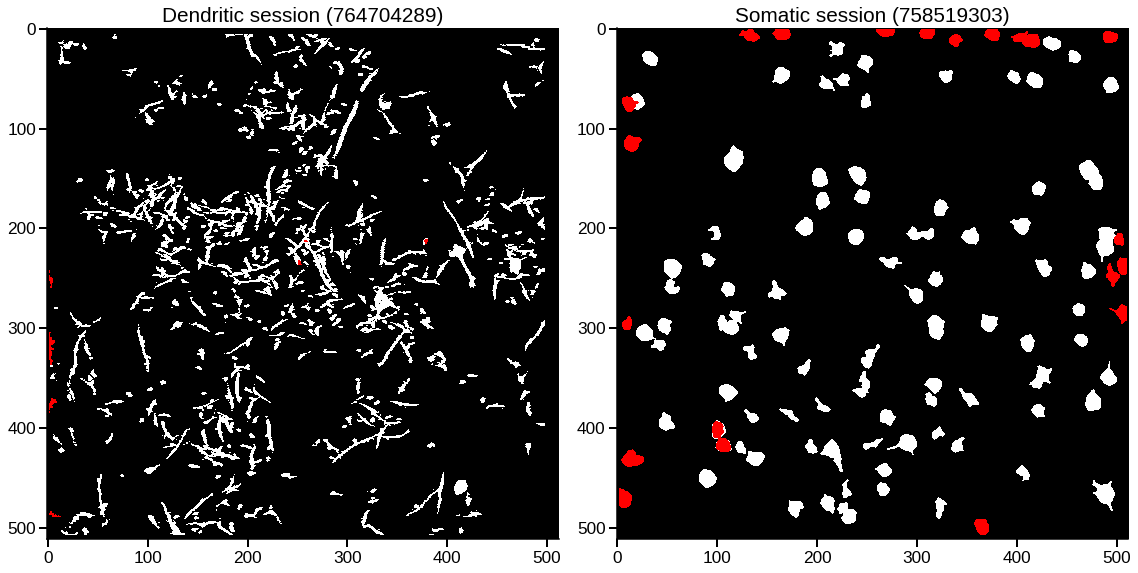

In [41]:
fig, ax = plt.subplots(1, 2, figsize=(16, 9))
if running_on_binder:
    ax[0].imshow(np.ones_like(soma_mask_all[0]), cmap="gray") # dummy image
    _ = ax[0].set_title(f"Dendritic session ({dend_sess.sessid}) (not loaded)")
else:
    sess_plot_util.plot_ROIs(ax[0], dend_mask_all, valid_mask=dend_valid)
    _ = ax[0].set_title(f"Dendritic session ({dend_sess.sessid})")

sess_plot_util.plot_ROIs(ax[1], soma_mask_all, valid_mask=soma_valid)
_ = ax[1].set_title(f"Somatic session ({soma_sess.sessid})")

### Visualizing ROI mask contours

`sess_plot_util.plot_ROI_contours()` can be used to visualize ROI contours, optionally restricted to around an ROI of interest.

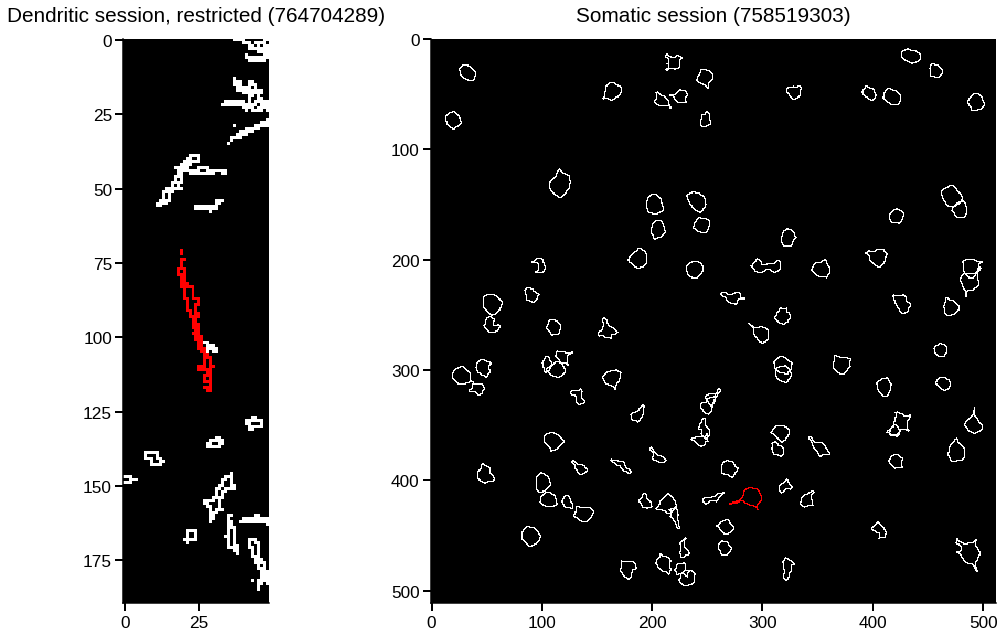

In [42]:
fig, ax = plt.subplots(1, 2, figsize=(16, 9))
if running_on_binder:
    # plot somata restricted, instead of dendrites restricted
    sess_plot_util.plot_ROI_contours(ax[0], soma_mask, outlier=30, restrict=True)
    _ = ax[0].set_title(f"Somatic session, restricted ({soma_sess.sessid})", y=1.02)
else:
    sess_plot_util.plot_ROI_contours(ax[0], dend_mask, outlier=490, restrict=True)
    _ = ax[0].set_title(f"Dendritic session, restricted ({dend_sess.sessid})", y=1.02)    
    
sess_plot_util.plot_ROI_contours(ax[1], soma_mask, outlier=30)
_ = ax[1].set_title(f"Somatic session ({soma_sess.sessid})", y=1.02)

## 7. Visualizing stimulus templates (NWB data only)
If using the NWB versions of the data, one should note that different NWB versions are available for each session, on the [Dandi archive](https://gui.dandiarchive.org/#/dandiset/000037).  

The basic versions are the smallest ones (~130 MB to 1.7 GB each), and contain all the data needed for most analyses. In contrast, the versions with `+image` in the name also contain the stimulus templates, i.e. all unique stimulus frame images. They are typically ~1.5 GB larger than the corresponding basic versions.  

We can load an example session: mouse 1, session 1, downloaded from the Dandi archive:  
[sub-408021/sub-408021_ses-20180926T172917_behavior+image+ophys.nwb](https://gui.dandiarchive.org/#/dandiset/000037/draft/files?location=sub-408021%2F).

In [43]:
if running_on_binder:
    %run ../sess_util/sess_download_util --mouse_ns 1 --sess_ns 1 --incl_stim_templates --output $datadir_nwb --mouse_df ../mouse_df.csv
else:
    print(
        "Be sure to download the file, and place it in the `datadir_nwb` "
        f"directory: {datadir_nwb}."
    )

Be sure to download the file, and place it in the `datadir_nwb` directory: ../../data/OSCA_NWB.


In [44]:
sess = session.Session(mouse_n=1, sess_n=1, datadir=datadir_nwb, mouse_df=mouse_df)
sess.extract_info(roi=False)

/home/colleen/Documents/OpenScope_CA_Analysis/analysis/session.py:287: UserWarning:
Several NWB files were found for this session. When loading data, the first file listed that contains the required data will be used.


Loading stimulus and alignment info...


As the warning indicates, the `Session` object has found both the basic version of the data for this session, and the version that also contains the stimulus template (`+image`) in the specified data directory. At any step where data must be loaded, the `Session` object will load it from the first listed version (alphabetically) that contains the required data.

### Gabor sequence images  
We can now identify the frame numbers for the **first Gabor sequence**, and **visualize** the corresponding stimulus images.

In [45]:
n_images = 5

# collect images for an expected sequence
exp_segs = sess.gabors.get_segs_by_criteria(unexp=0)[:n_images]
exp_stim_fr_ns = sess.gabors.get_fr_by_seg(exp_segs, start=True, fr_type="stim")["start_frame_stim"]
exp_stim_images = sess.gabors.get_stim_images_by_frame(exp_stim_fr_ns)
exp_frame_names = ["A", "B", "C", "D", "G"]

# collect images for an unexpected sequence
unexp_segs = sess.gabors.get_segs_by_criteria(unexp=1)[:n_images]
unexp_stim_fr_ns = sess.gabors.get_fr_by_seg(unexp_segs, start=True, fr_type="stim")["start_frame_stim"]
unexp_stim_images = sess.gabors.get_stim_images_by_frame(unexp_stim_fr_ns)
unexp_frame_names = ["A", "B", "C", "U", "G"]

In [46]:
def plot_images(images, suptitle=None, titles=None):
    n_images = len(images)
    fig, ax = plt.subplots(ncols=n_images, figsize=(4 * n_images, 3))
    if suptitle is not None:
        fig.suptitle(suptitle, y=1.01)
    if titles is not None and len(titles) != len(images):
        raise ValueError(
            "If provided, 'titles' must have the same length as 'images'."
        )
    vmin = np.min(images)
    vmax = np.max(images)
    for i, image in enumerate(images):
        if titles is not None:
            ax[i].set_title(titles[i])
        ax[i].imshow(image, cmap="gray", vmin=vmin, vmax=vmax)
        ax[i].set_xticks([])
        ax[i].set_yticks([])

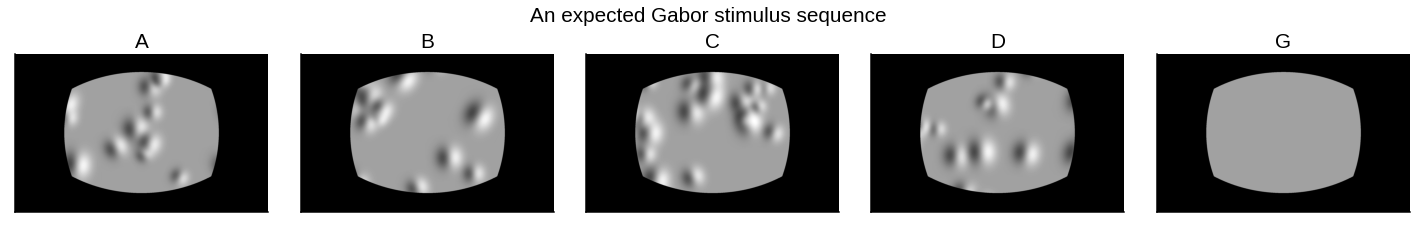

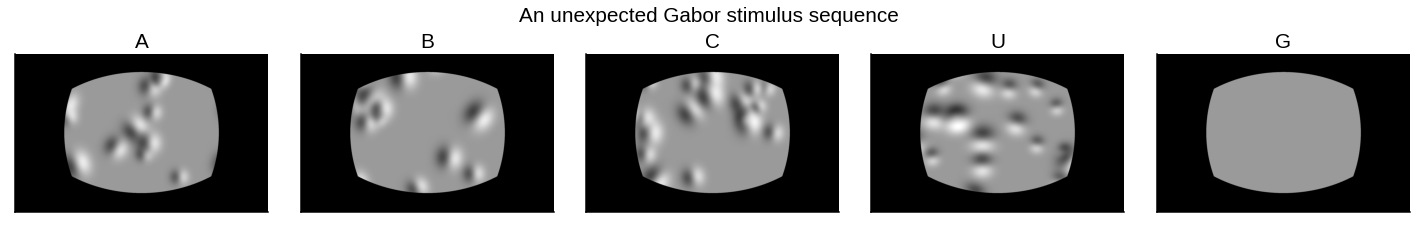

In [47]:
# plot images for the expected sequence
suptitle = "An expected Gabor stimulus sequence"
plot_images(exp_stim_images, suptitle, titles=exp_frame_names)

# plot images for the unexpected sequence
suptitle = "An unexpected Gabor stimulus sequence"
plot_images(unexp_stim_images, suptitle, titles=unexp_frame_names)

As we can see, whereas the Gabor patch orientations are consistent across frames in the expected sequence, they are rotated by 90&deg; in the U frame of the unexpected sequence.

### Warping
Note that the periphery of the images is masked in black. This is because, during the actual stimulus presentation, the images were presented on a **flat screen, and spherically warped**. This ensured that the apparent properties of the stimuli (size, speed, spatial frequency, etc.) were constant across the monitor, as seen from the mice’s perspectives. The black masks overlayed on the unwarped stimuli stored in the NWB file, therefore, **mask the parts of the stimuli that were** outside the edges of the screen, due to warping, and thus **not visible** to the mice during the experiments.

### Visual flow sequence images  
We can also visualize the **visual flow stimulus**. It is important to note that, whereas the Gabor images are static for each segment, the visual flow stimulus is in motion, and therefore changes at each frame. For this reason, we will simply identify the first visual flow segment in a sequence, and visualize the first few frames in that follow it.

In [48]:
n_images = 15

# collect images for a visual flow sequence
exp_vfl_segs = sess.visflow.get_segs_by_criteria(unexp=0)[0:1]
exp_vfl_stim_fr_n = sess.visflow.get_fr_by_seg(
        exp_vfl_segs, start=True, fr_type="stim"
    )["start_frame_stim"].tolist()[0]
exp_vfl_stim_fr_ns = np.arange(exp_vfl_stim_fr_n, exp_vfl_stim_fr_n + n_images)
exp_vlf_stim_images = sess.visflow.get_stim_images_by_frame(exp_vfl_stim_fr_ns)

# collect images for a visual flow sequence
unexp_vfl_segs = sess.visflow.get_segs_by_criteria(unexp=1)[0:1]
unexp_vfl_stim_fr_n = sess.visflow.get_fr_by_seg(
        unexp_vfl_segs, start=True, fr_type="stim"
    )["start_frame_stim"].tolist()[0]
unexp_vfl_stim_fr_ns = np.arange(unexp_vfl_stim_fr_n, unexp_vfl_stim_fr_n + n_images)
unexp_vlf_stim_images = sess.visflow.get_stim_images_by_frame(unexp_vfl_stim_fr_ns)

In [49]:
def plot_images_in_motion(images, suptitle=None):
    fig, ax = plt.subplots(1, figsize=(4, 3))
    weights = np.linspace(0.2, 1.0, len(images))
    if suptitle is not None:
        fig.suptitle(suptitle, y=1.01)
    overlayed_image = np.max(np.moveaxis(images, 0, -1) * weights, axis=-1)
    ax.imshow(overlayed_image, cmap="gray")
    ax.set_xticks([])
    ax.set_yticks([])

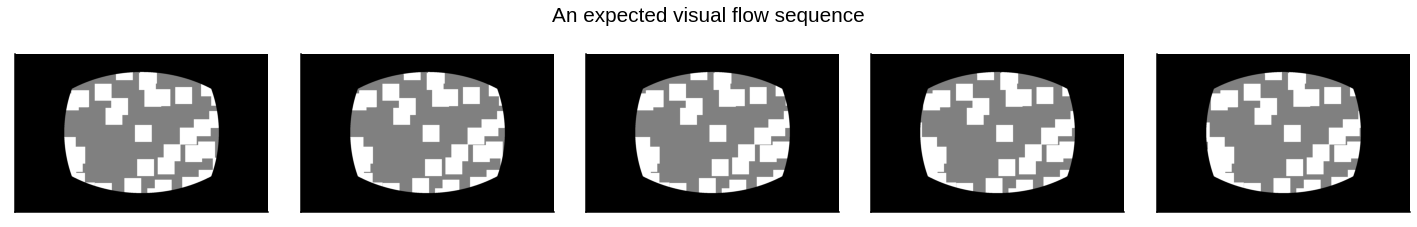

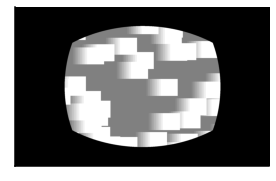

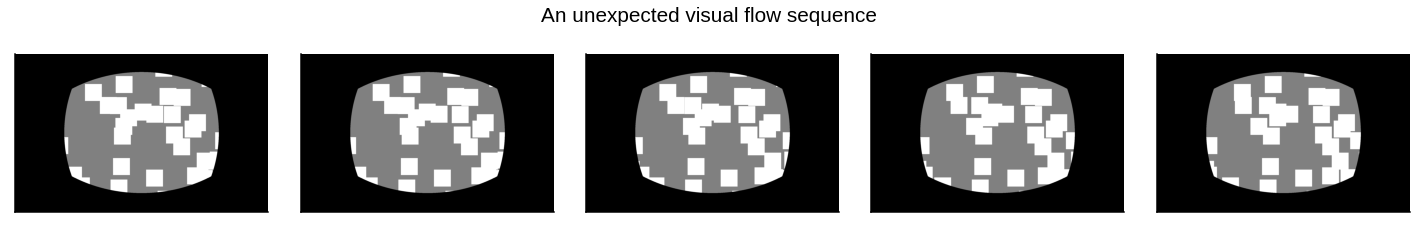

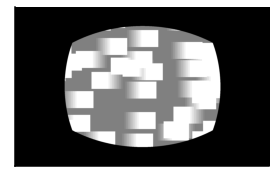

In [50]:
# plot images for the expected sequence
suptitle = "An expected visual flow sequence"
plot_images(exp_vlf_stim_images[:5], suptitle)
plot_images_in_motion(exp_vlf_stim_images)

# plot images for the unexpected sequence
suptitle = "An unexpected visual flow sequence"
plot_images(unexp_vlf_stim_images[:5], suptitle)
plot_images_in_motion(unexp_vlf_stim_images)

We plot the first few frames in each sequence separately. We then also plot all the frames retained for each sequence, **overlayed in a graded way**, in order to visualize the squares **in motion**.

As we can see, in the **expected** sequence, all of the squares are moving rightward, uniformly. In contrast, in the **unexpected** sequence, although most squares are still moving rightward, ~25% of them are moving in the opposite direction, i.e., leftward. 

### Stimulus generating code and examples
This [repository](https://github.com/colleenjg/cred_assign_stimuli) contains the code to generate these stimuli, as well as some example videos.

## 8. Last notes

There is much more to the codebase, and even to the `Session` and `Stim` objects, and almost all functions and methods are thoroughly documented.

When looking to implement a new analysis, consider checking to see whether relevant functions have already been implemented in:  
* `analysis/session.py`  
* `analysis/basic_analys.py`  
* `sess_util/sess_gen_util.py`  

### Methods/properties attached to `Session` and `Stim` objects.

In [51]:
# First, just finish loading all data in the Session object
sess.extract_info(roi=True, pupil=True, run=True)

Loading stimulus and alignment info...
Loading ROI trace info...
Loading running info...
Loading pupil info...


In [52]:
print(f"{sess}{gen_util.create_attribute_str(sess)}")

Session (758519303)

  Public properties:
    self.all_files
    self.any_files
    self.dandi_id
    self.date
    self.dend
    self.depth
    self.drop_tol
    self.gabors
    self.grayscr
    self.home
    self.line
    self.max_proj
    self.mouse_df
    self.mouse_n
    self.mouseid
    self.n_stims
    self.notes
    self.nwb
    self.only_tracked_rois
    self.pass_fail
    self.plane
    self.pup_data
    self.pup_data_available
    self.roi_facts_df
    self.roi_masks
    self.roi_names
    self.run_data
    self.runtype
    self.sess_files
    self.sess_n
    self.sessid
    self.stim2twopfr
    self.stim_df
    self.stim_fps
    self.stim_seed
    self.stims
    self.stimtypes
    self.tot_stim_fr
    self.tot_twop_fr
    self.tracked_rois
    self.twop2stimfr
    self.twop_fps
    self.visflow

  Public methods:
    self.check_flanks()
    self.convert_frames()
    self.data_loaded()
    self.extract_info()
    self.get_active_rois()
    self.get_bad_rois()
    self.get_fr

In [53]:
print(f"{sess.gabors}{gen_util.create_attribute_str(sess.gabors)}")

Gabors (stimulus from session 758519303)

  Public properties:
    self.all_gabfr
    self.all_gabfr_mean_oris
    self.block_params
    self.deg_per_pix
    self.exp_gabfr
    self.exp_gabfr_mean_oris
    self.exp_max_s
    self.exp_min_s
    self.kappas
    self.n_patches
    self.n_segs_per_seq
    self.ori_ran
    self.phase
    self.seg_len_s
    self.sess
    self.sf
    self.size_ran
    self.stim_fps
    self.stim_params
    self.stimtype
    self.unexp_gabfr
    self.unexp_gabfr_mean_oris
    self.unexp_max_s
    self.unexp_min_s
    self.win_size

  Public methods:
    self.get_A_frame_1s()
    self.get_A_segs()
    self.get_all_unexp_segs()
    self.get_all_unexp_stim_fr()
    self.get_fr_by_seg()
    self.get_frames_by_criteria()
    self.get_n_fr_by_seg()
    self.get_pup_diam_data()
    self.get_pup_diam_stats_df()
    self.get_roi_data()
    self.get_roi_stats_df()
    self.get_run()
    self.get_run_data()
    self.get_run_stats_df()
    self.get_segs_by_criteria()
    

In [54]:
print(f"{sess.visflow}{gen_util.create_attribute_str(sess.visflow)}")

Visflow (stimulus from session 758519303)

  Public properties:
    self.block_params
    self.deg_per_pix
    self.exp_max_s
    self.exp_min_s
    self.main_flow_direcs
    self.n_squares
    self.prop_flipped
    self.seg_len_s
    self.sess
    self.speed
    self.square_sizes
    self.stim_fps
    self.stim_params
    self.stimtype
    self.unexp_max_s
    self.unexp_min_s
    self.win_size

  Public methods:
    self.get_all_unexp_segs()
    self.get_all_unexp_stim_fr()
    self.get_dir_segs_exp()
    self.get_fr_by_seg()
    self.get_frames_by_criteria()
    self.get_n_fr_by_seg()
    self.get_pup_diam_data()
    self.get_pup_diam_stats_df()
    self.get_roi_data()
    self.get_roi_stats_df()
    self.get_run()
    self.get_run_data()
    self.get_run_stats_df()
    self.get_segs_by_criteria()
    self.get_segs_by_frame()
    self.get_start_unexp_segs()
    self.get_start_unexp_stim_fr_trans()
    self.get_stats_df()
    self.get_stim_beh_sub_df()
    self.get_stim_df_by_criteri

In [55]:
print(f"{sess.grayscr}{gen_util.create_attribute_str(sess.grayscr)}")

Grayscr (session 758519303)

  Public properties:
    self.sess
    self.stimtype

  Public methods:
    self.get_all_fr()
    self.get_start_fr()
    self.get_stim_images_by_frame()
    self.get_stop_fr()


### Example `Session` and `Stim` object property values.
 Properties with long values (e.g., long dataframes, arrays, lists, strings) are omitted, for brevity.

In [56]:
print(f"{sess}{gen_util.create_property_str(sess, max_length=40)}")

Session (758519303)

  Public property values:
    self.all_files: True
    self.any_files: True
    self.dandi_id: 20180926T172917
    self.date: 20180926
    self.dend: extr
    self.depth: 175
    self.drop_tol: 0.0003
    self.gabors: Gabors (stimulus from session 758519303)
    self.grayscr: Grayscr (session 758519303)
    self.home: ../../data/OSCA_NWB
    self.line: L23-Cux2
    self.mouse_n: 1
    self.mouseid: 408021
    self.n_stims: 2
    self.notes: nan
    self.nwb: True
    self.only_tracked_rois: False
    self.pass_fail: P
    self.plane: soma
    self.pup_data_available: True
    self.runtype: prod
    self.sess_n: 1
    self.sessid: 758519303
    self.stim_fps: 59.951703429774675
    self.stim_seed: 30587
    self.stimtypes: ['gabors', 'visflow']
    self.tot_stim_fr: 251999
    self.tot_twop_fr: 126741
    self.twop2stimfr: [nan nan nan ... nan nan nan]
    self.twop_fps: 30.078983328254086


In [57]:
print(f"{sess.gabors}{gen_util.create_property_str(sess.gabors, max_length=40)}")

Gabors (stimulus from session 758519303)

  Public property values:
    self.all_gabfr: ['A', 'B', 'C', 'D', 'G', 'U']
    self.all_gabfr_mean_oris: [0.0, 45.0, 90.0, 135.0, 180.0, 225.0]
    self.deg_per_pix: 0.06251912565744862
    self.exp_gabfr: ['A', 'B', 'C', 'D', 'G']
    self.exp_gabfr_mean_oris: [0.0, 45.0, 90.0, 135.0]
    self.exp_max_s: 90
    self.exp_min_s: 30
    self.kappas: [16]
    self.n_patches: 30
    self.n_segs_per_seq: 5
    self.ori_ran: [0, 360]
    self.phase: 0.25
    self.seg_len_s: 0.3
    self.sess: Session (758519303)
    self.sf: 0.04
    self.size_ran: [204, 408]
    self.stim_fps: 59.951703429774675
    self.stim_params: ['gabor_kappa']
    self.stimtype: gabors
    self.unexp_gabfr: ['U']
    self.unexp_gabfr_mean_oris: [90.0, 135.0, 180.0, 225.0]
    self.unexp_max_s: 6
    self.unexp_min_s: 3
    self.win_size: [1920, 1200]


In [58]:
print(f"{sess.visflow}{gen_util.create_property_str(sess.visflow, max_length=40)}")

Visflow (stimulus from session 758519303)

  Public property values:
    self.deg_per_pix: 0.06251912565744862
    self.exp_max_s: 90
    self.exp_min_s: 30
    self.main_flow_direcs: ['left (nasal)', 'right (temp)']
    self.n_squares: [105]
    self.prop_flipped: 0.25
    self.seg_len_s: 1
    self.sess: Session (758519303)
    self.speed: 799.7552664756905
    self.square_sizes: [128]
    self.stim_fps: 59.951703429774675
    self.stimtype: visflow
    self.unexp_max_s: 4
    self.unexp_min_s: 2
    self.win_size: [1920, 1200]


In [59]:
print(f"{sess.grayscr}{gen_util.create_property_str(sess.grayscr, max_length=40)}")

Grayscr (session 758519303)

  Public property values:
    self.sess: Session (758519303)
    self.stimtype: grayscreen
